# 11 - Jointly Learning to Align and Translate
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

In this notebook, we'll implement the model in the paper Neural Machine Translation by Jointly Learning to Align and Translate (Bahadanau et al., 2014). We'll use attention to improve our translations performance-wise and interpretability-wise.

# Preliminaries

First, let's make sure we have a GPU.

In [ ]:
!nvidia-smi

Fri Sep  4 11:29:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Download the data and the tokenizers as with the previous notebook. Don't forget to restart the runtime.

In [ ]:
!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/translation/multi30k.zip
!unzip multi30k.zip && rm multi30k.zip
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

Then it's our usual imports.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datautils

import spacy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

import random
from collections import Counter
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

# Data Processing

We'll do the same thing here as with the last notebook, so we'll breeze through this. Load the data.

In [ ]:
with open('multi30k/train.en', 'r') as f:
    train_en = [line.strip() for line in f]
with open('multi30k/train.de', 'r') as f:
    train_de = [line.strip() for line in f]
with open('multi30k/val.en', 'r') as f:
    valid_en = [line.strip() for line in f]
with open('multi30k/val.de', 'r') as f:
    valid_de = [line.strip() for line in f]

Load the tokenizers then tokenize the dataset and add the delimiter tokens.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return ['<sos>'] + [tok.text.lower() for tok in spacy_de.tokenizer(text)] + ['<eos>']

def tokenize_en(text):
    return ['<sos>'] + [tok.text.lower() for tok in spacy_en.tokenizer(text)] + ['<eos>']

# Tokenize the text
train_en = [tokenize_en(text) for text in tqdm(train_en)]
train_de = [tokenize_de(text) for text in tqdm(train_de)]
valid_en = [tokenize_en(text) for text in tqdm(valid_en)]
valid_de = [tokenize_de(text) for text in tqdm(valid_de)]

100%|██████████| 1014/1014 [00:00<00:00, 15986.59it/s]


Process each sequence to the maximum sequence length of the dataset.

In [ ]:
def process(dataset):
    max_len = max([len(text) for text in dataset])
    temp = []
    for text in dataset:
        if len(text) < max_len:
            text += ['<pad>' for _ in range(max_len - len(text))]
        temp.append(text)
    return temp

# Pad to maximum length of the dataset
train_en_proc, valid_en_proc = process(train_en), process(valid_en)
train_de_proc, valid_de_proc = process(train_de), process(valid_de)

Produce vocabularies for the source and target languages.

In [ ]:
def get_vocab(dataset, min_freq=2):
    # Add all tokens to the list
    special_tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
    vocab = []
    for line in dataset: vocab.extend(line)

    # Remove words that are below the minimum frequency, the enforce set
    counts = Counter(vocab)
    vocab = special_tokens + [word for word in counts.keys() if counts[word] > min_freq]
    vocab_set = set(vocab)

    # Push all special tokens to the front
    idx2word = list(vocab_set)
    for token in special_tokens[::-1]:
        idx2word.insert(0, idx2word.pop(idx2word.index(token)))

    # Produce word2idx then return
    word2idx = {idx2word[i]: i for i in range(len(idx2word))}
    return vocab_set, idx2word, word2idx

# Get vocabulary and references
vocab_set_en, idx2word_en, word2idx_en = get_vocab(train_en_proc, min_freq=2)
vocab_set_de, idx2word_de, word2idx_de = get_vocab(train_de_proc, min_freq=2)

# Convert unknown tokens
train_en_proc = [[token if token in vocab_set_en else '<unk>' for token in line] for line in train_en_proc]
train_de_proc = [[token if token in vocab_set_de else '<unk>' for token in line] for line in train_de_proc]
valid_en_proc = [[token if token in vocab_set_en else '<unk>' for token in line] for line in valid_en_proc]
valid_de_proc = [[token if token in vocab_set_de else '<unk>' for token in line] for line in valid_de_proc]

Finally, convert the sequences of tokens into their corresponding indices.

In [ ]:
def serialize(dataset, word2idx):
    temp = []
    for line in dataset: temp.append([word2idx[token] for token in line])
    return torch.LongTensor(temp)

# Convert to idx
y_train = serialize(train_en_proc, word2idx_en)
X_train = serialize(train_de_proc, word2idx_de)
y_valid = serialize(valid_en_proc, word2idx_en)
X_valid = serialize(valid_de_proc, word2idx_de)

We'll wrap up by making dataloaders.

In [ ]:
bs = 128

train_dataset = datautils.TensorDataset(X_train, y_train)
valid_dataset = datautils.TensorDataset(X_valid, y_valid)
train_sampler = datautils.RandomSampler(train_dataset)
train_loader = datautils.DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
valid_loader = datautils.DataLoader(valid_dataset, batch_size=bs, shuffle=False)

# Modeling

Let's start with the encoder. The biggest change here is that we're using a bidirectional GRU instead of a vanilla LSTM. Since the RNN is bidirectional, we'll introduce a linear layer to **pool** the forward and backward hidden states.

Encoding the source sequence remains the same. We'll embed and apply dropout. Afterwhich, we'll pack the sequences to disregard padding. Pass that result to the GRU, then unpack the result. We pass the concatenated hidden states to the linear pooling layer, then apply a hyperbolic tangent activation function. This tells us which "candidate information" to keep.

To prepare for attention, we'll output both the RNN output and the pooled hidden states.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, enc_hidden_dim, dec_hidden_dim, dropout=0.5):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, enc_hidden_dim, bidirectional=True)
        self.fc1 = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.vocab_sz = vocab_sz

    def init_hidden(self, bs):
        weight = next(self.parameters())
        hidden_dim = self.rnn.hidden_size

        h = weight.new_zeros(2, bs, hidden_dim)
        return h

    def forward(self, x, pad_idx):
        msl, bs = x.shape

        # Embed then pack the sequence
        out = self.embedding(x)
        out = self.dropout(out)

        # Get the length of the sequences and pack them
        lens = ((x.rot90() == pad_idx) == False).int().sum(dim=1)
        out = nn.utils.rnn.pack_padded_sequence(out, lens, enforce_sorted=False)

        hidden = self.init_hidden(bs)
        out, hidden = self.rnn(out, hidden)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, total_length=msl)

        # Pool the forward and backward states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), axis=1)
        hidden = torch.tanh(self.fc1(hidden))

        return out, hidden

For the rest of the modeling part, we'll run through attention and decoding manually as things can get rather confusing. 

First, let's get a sample source and target sequence batch.

In [ ]:
x, y = next(iter(train_loader))
x, y = x.rot90(k=3), y.rot90(k=3)
print(x.shape, y.shape)

torch.Size([46, 128]) torch.Size([43, 128])


Here's our hyperparameters.

In [ ]:
vocab_sz = len(vocab_set_de)
embedding_dim = 128
enc_hidden_dim = 256
dec_hidden_dim = 256
pad_idx = word2idx_de['<pad>']

Instantiate an encoder.

In [ ]:
encoder = Encoder(vocab_sz, embedding_dim, enc_hidden_dim, dec_hidden_dim)

Then pass the source sentence.

We get what we expect.

In [ ]:
out, hidden = encoder(x, pad_idx=pad_idx)
print(out.shape, hidden.shape)

torch.Size([46, 128, 512]) torch.Size([128, 256])


Time to compute the attention weights!

Attention weights can be thought of as a form of "feature importance." We'll use the RNN outputs of the encoder and the pooled hidden states to output a matrix of size [bs $\times$ sequence length]. This can be thought of as the "feature importance" of each token in the sequence given the current information (the hidden states).

At every decoding timestep, we will produce this attention matrix (or attention vector per sequence) to tell our model which tokens are important at each step. This gives the model the ability to "look back" and "focus on important context tokens."

Anyhow, we'll implement an attention layer using two linear layers.

In [ ]:
attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim) 
v = nn.Linear(dec_hidden_dim, 1, bias=False)

We'll take the length of the source sentence and the batch size.

In [ ]:
src_len, bs, _ = out.shape

Here's what we're going to do:
1. We need to match the hidden state to each output token. If, for example, the sequence has 50 tokens, we need to 50 copies of the hidden state to "match" to each output token.
2. We'll compute the "energy" between the hidden state and the output. Think of this as "how much does a specific token match the information in the hidden state. If it is more relevant, energy is higher."
3. Once we have our energy, we need to turn them into weights. These are the weights of each token at a certain timestep. In other words, the "importance."

Let's do #1 first. Remember the hidden state's shape:

In [ ]:
hidden.shape

torch.Size([128, 256])

Let's introduce a blank dimension.

In [ ]:
hidden.unsqueeze(1).shape

torch.Size([128, 1, 256])

Then repeat the hidden state src_len times. This makes a number of clones of the hidden state that we can match to every entry in the RNN outputs.

In [ ]:
hidden_repeated = hidden.unsqueeze(1).repeat(1, src_len, 1)
hidden_repeated.shape

torch.Size([128, 46, 256])

As a sanity check:

In [ ]:
hidden_repeated[:, 0, :] == hidden_repeated[:, 1, :]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

Now here's our output shape:

In [ ]:
out.shape

torch.Size([46, 128, 512])

We'll permute the dimensions to match our hidden state clones:

In [ ]:
out_permuted = out.permute(1, 0, 2)
out_permuted.shape

torch.Size([128, 46, 512])

Since their dimensions are now matched, we can concatenate them on the last dimension. This should now be of shape [batch size $\times$ src_len $\times$ encoder hidden dim * 2 + decoder hidden dim]

Remember that we're doing encoder hidden dim * 2 because our encoder uses a bidirectional RNN.

In [ ]:
torch.cat((out_permuted, hidden_repeated), dim=2).shape

torch.Size([128, 46, 768])

Pass the concatenated hidden and outputs to a linear layer to compute new features, then apply a hyperbolic tangent activation function.

In [ ]:
energy = attn(torch.cat((out_permuted, hidden_repeated), dim=2))
energy = torch.tanh(energy)
energy.shape

torch.Size([128, 46, 256])

We still have a 3D tensor. Let's project this down to 2 dimensions by applying a final linear transform. This turns our energy into a "weight matrix."

In [ ]:
a = v(energy)
a.shape

torch.Size([128, 46, 1])

Squeeze the final dimension since there's nothing there.

In [ ]:
a = a.squeeze(2)
a.shape

torch.Size([128, 46])

We're not yet done. Lastly, we have to mask out the attention weights on the padding tokens. We can do this by using an attention mask.

In [ ]:
mask = (x != pad_idx).permute(1, 0)
mask.shape

torch.Size([128, 46])

It looks like this.

In [ ]:
mask

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

To mask the padding tokens, we'll do it like so:

In [ ]:
a = a.masked_fill(mask == 0, -1e10)

The full attention layer looks like this:

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, out, hidden, mask):
        src_len, bs, _ = out.shape
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        out = out.permute(1, 0, 2)

        # Compute the weighted energy (match between hidden states)
        energy = torch.tanh(self.attention(torch.cat((out, hidden), dim=2)))
        attn = self.v(energy).squeeze(2)
        attn = attn.masked_fill(mask == 0, -1e10)

        return torch.softmax(attn, dim=1)

Instantiate an attention layer for testing.

In [ ]:
attention = Attention(enc_hidden_dim, dec_hidden_dim)

Using it gives us the outputs we expect.

In [ ]:
mask = (x != pad_idx).permute(1, 0)
a = attention(out, hidden, mask)
a.shape

torch.Size([128, 46])

Lastly, we'll implement the decoder.

We have a few differences from the previous decoder.
1. Our RNN is again a GRU, which accepts encoder hidden dim * 2 + embedding dim shaped inputs. This is because we're passing it the encoded source sentence (remember the encoder is bidirectional) along with the embedded target token.
2. We use attention inside the decoder. At every decoding step, we generate a new attention matrix, which we batch matrix multiply to the outputs of the encoder. This lets the decoder know which tokens in the source sentence it should "pay attention to."

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, enc_hidden_dim, dec_hidden_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.attention = Attention(enc_hidden_dim, dec_hidden_dim)
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.rnn = nn.GRU((enc_hidden_dim * 2) + embedding_dim, dec_hidden_dim)
        self.fc1 = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim + embedding_dim, vocab_sz)
        self.dropout = nn.Dropout(dropout)
        self.vocab_sz = vocab_sz

    def forward(self, y, out, hidden, mask):
        embedded = self.embedding(y.unsqueeze(0))
        embedded = self.dropout(embedded)

        # Batch multiply to get weighted outputs
        a = self.attention(out, hidden, mask).unsqueeze(1)
        out = out.permute(1, 0, 2)
        weighted = torch.bmm(a, out).permute(1, 0, 2)

        # Prepare RNN Inputs
        rnn_inputs = torch.cat((embedded, weighted), dim=2)
        hidden = hidden.unsqueeze(0)
        out, hidden = self.rnn(rnn_inputs)

        # Pool the embeddings, weighted outputs, and new outputs
        out = torch.cat((embedded.squeeze(0), out.squeeze(0), weighted.squeeze(0)), dim=1)
        out = self.fc1(out)

        return out, hidden.squeeze(0), a.squeeze(1)

Let's set the first input token for example.

In [ ]:
token = y[0,:]
print(token.shape)
print(token)

torch.Size([128])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


Instantiate a decoder.

In [ ]:
decoder = Decoder(vocab_sz, embedding_dim, enc_hidden_dim, dec_hidden_dim)

Produce a mask and pass in the output, hidden states, and the mask.

In [ ]:
mask = (x != pad_idx).permute(1, 0)
out, hidden, a = decoder(token, out, hidden, mask)
print(out.shape, hidden.shape, a.shape)

torch.Size([128, 5376]) torch.Size([128, 256]) torch.Size([128, 46])


Getting the maximum of the logits gives us the predicted next output token.

In [ ]:
out.argmax(1)

tensor([3621, 3832, 1783, 5105,  680, 5105, 1335, 4930, 1225,  130, 4532, 2071,
        3155, 4491, 2071, 5288, 2271, 3368, 3600, 2719, 4941, 4722, 3832,  644,
        2271, 3549, 3435, 4836, 4905, 1571, 2271, 4746, 2747, 1848, 2691, 1547,
        2271, 1952, 3901, 1848, 1848, 4207, 5288, 1952, 4496, 3435, 4605, 4941,
        3892, 2370, 4411, 2134, 2050, 2405, 4819, 4415, 2292, 2590, 4415, 2590,
        2691,  215, 4952, 3435, 5105, 4415,  130, 1053, 4351, 2071, 4415, 5026,
         551, 3435,  523, 5105, 4415, 4836, 5028, 3800,  678, 2590, 3023, 4836,
        2468, 5105, 2590, 3588, 1848,  940, 2271, 2086,  644, 2590, 3978, 2271,
        4351,  477, 5028, 3832, 4351, 2254, 2548, 3625, 2271, 5105, 5288, 2271,
        4207, 5288, 1848, 4705, 4215, 4964, 2271, 4941, 3368,  613, 2590, 2071,
        3856, 1715,  433, 2405, 3832, 4836, 2271, 3643])

Let's wrap the encoder and decoder in a seq2seq module. This is largely the same, except we include a helper function to generate an attention mask.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, initrange=0.01):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_weights(initrange)
        self.pad_idx = pad_idx

    def create_mask(self, x):
        with torch.no_grad():
            mask = (x != self.pad_idx).permute(1, 0)
        return mask

    def init_weights(self, initrange=0.01):
        for name, param in self.named_parameters():
            if 'weight' in name: nn.init.normal_(param.data, mean=0, std=initrange)
            else: nn.init.constant_(param.data, 0)

    def forward(self, x, y, teacher_forcing=0.5):
        src_len, bs = x.shape
        trg_len, bs = y.shape

        # Make container for outputs
        weight = next(self.encoder.parameters())
        outputs = weight.new_zeros(trg_len, bs, self.decoder.vocab_sz)

        # Encode source then remember context
        encoder_out, hidden = self.encoder(x, self.pad_idx)
        input_ids = y[0,:]
        mask = self.create_mask(x)

        # Decode per input token
        for i in range(1, trg_len):
            out, hidden, _ = self.decoder(input_ids, encoder_out, hidden, mask)
            outputs[i] = out

            teacher_force = random.random() < teacher_forcing
            input_ids = y[i] if teacher_force else out.argmax(1)

        return outputs

Test out the wrapper and instantiate a loss function.

In [ ]:
model = Seq2Seq(encoder, decoder, pad_idx)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

We get the expected output.

In [ ]:
out = model(x, y)
print(out.shape)

torch.Size([43, 128, 5376])


Here's the initial loss.

In [ ]:
loss = criterion(out[1:].flatten(0, 1), y[1:].flatten(0))
print(loss)

tensor(8.5897, grad_fn=<NllLossBackward>)


# Training

We'll instantiate a training setup with the following hyperparameters:

In [ ]:
encoder = Encoder(vocab_sz=len(vocab_set_de), embedding_dim=256, enc_hidden_dim=512, dec_hidden_dim=512, dropout=0.5)
decoder = Decoder(vocab_sz=len(vocab_set_en), embedding_dim=256, enc_hidden_dim=512, dec_hidden_dim=512, dropout=0.5)
model = Seq2Seq(encoder, decoder, pad_idx=word2idx_de['<pad>']).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_en['<pad>'])

epochs = 20
iters = epochs * len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

Count the parameters of the model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 17,144,780 trainable parameters


For transparency, here's the final architecture of our model:

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5376, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(4556, 256)
    (rnn): GRU(1280, 512)
    (fc1): Linear(in_features=1792, out_features=4556, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Finally, we'll train it.

In [ ]:
clip = 1.0

for e in range(1, epochs + 1):
    train_loss = 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.rot90(k=3).to(device), y.rot90(k=3).to(device)

        out = model(x, y)
        loss = criterion(out[1:].flatten(0, 1), y[1:].flatten(0))
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    valid_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.rot90(k=3).to(device), y.rot90(k=3).to(device)

            out = model(x, y)
            loss = criterion(out[1:].flatten(0, 1), y[1:].flatten(0))

            valid_loss += loss.item()
    valid_loss /= len(valid_loader)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Ppl {:.4f} | Valid Loss {:.4f} | Valid Ppl {:.4f}".format(e, train_loss, np.exp(train_loss), valid_loss, np.exp(valid_loss)))

  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   1 | Train Loss 4.4800 | Train Ppl 88.2326 | Valid Loss 3.3907 | Valid Ppl 29.6880


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   2 | Train Loss 3.1819 | Train Ppl 24.0927 | Valid Loss 2.8464 | Valid Ppl 17.2253


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   3 | Train Loss 2.7285 | Train Ppl 15.3099 | Valid Loss 2.5859 | Valid Ppl 13.2758


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   4 | Train Loss 2.4235 | Train Ppl 11.2850 | Valid Loss 2.6369 | Valid Ppl 13.9702


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   5 | Train Loss 2.2290 | Train Ppl 9.2909 | Valid Loss 2.5845 | Valid Ppl 13.2569


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   6 | Train Loss 2.0413 | Train Ppl 7.7008 | Valid Loss 2.5946 | Valid Ppl 13.3906


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   7 | Train Loss 1.9002 | Train Ppl 6.6869 | Valid Loss 2.4999 | Valid Ppl 12.1817


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   8 | Train Loss 1.7836 | Train Ppl 5.9512 | Valid Loss 2.5999 | Valid Ppl 13.4626


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch   9 | Train Loss 1.6776 | Train Ppl 5.3527 | Valid Loss 2.6190 | Valid Ppl 13.7226


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  10 | Train Loss 1.5827 | Train Ppl 4.8683 | Valid Loss 2.5018 | Valid Ppl 12.2044


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  11 | Train Loss 1.4930 | Train Ppl 4.4505 | Valid Loss 2.5336 | Valid Ppl 12.5986


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  12 | Train Loss 1.3999 | Train Ppl 4.0548 | Valid Loss 2.6065 | Valid Ppl 13.5521


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  13 | Train Loss 1.3385 | Train Ppl 3.8131 | Valid Loss 2.6673 | Valid Ppl 14.4012


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  14 | Train Loss 1.2878 | Train Ppl 3.6248 | Valid Loss 2.7561 | Valid Ppl 15.7385


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  15 | Train Loss 1.2174 | Train Ppl 3.3784 | Valid Loss 2.7530 | Valid Ppl 15.6891


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  16 | Train Loss 1.1627 | Train Ppl 3.1987 | Valid Loss 2.6896 | Valid Ppl 14.7252


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  17 | Train Loss 1.1452 | Train Ppl 3.1430 | Valid Loss 2.7360 | Valid Ppl 15.4245


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  18 | Train Loss 1.1133 | Train Ppl 3.0445 | Valid Loss 2.6830 | Valid Ppl 14.6292


  0%|          | 0/227 [00:00<?, ?it/s]


Epoch  19 | Train Loss 1.1155 | Train Ppl 3.0510 | Valid Loss 2.7666 | Valid Ppl 15.9037


100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


Epoch  20 | Train Loss 1.1105 | Train Ppl 3.0360 | Valid Loss 2.6433 | Valid Ppl 14.0602


If you train your own model, make sure to save the resulting weights.

In [ ]:
torch.save(model.state_dict(), 'seq2seq_attention.pt')

# Sampling

Let's load the pretrained weights.

In [ ]:
encoder = Encoder(vocab_sz=len(vocab_set_de), embedding_dim=256, enc_hidden_dim=512, dec_hidden_dim=512, dropout=0.5)
decoder = Decoder(vocab_sz=len(vocab_set_en), embedding_dim=256, enc_hidden_dim=512, dec_hidden_dim=512, dropout=0.5)
model = Seq2Seq(encoder, decoder, pad_idx=word2idx_de['<pad>']).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_en['<pad>'])

model.load_state_dict(torch.load('seq2seq_attention.pt'))
model.eval();

Evaluate them on the validation set.

In [ ]:
model.eval()
valid_loss = 0
with torch.no_grad():
    for x, y in tqdm(valid_loader):
        x, y = x.rot90(k=3).to(device), y.rot90(k=3).to(device)

        out = model(x, y)
        loss = criterion(out[1:].flatten(0, 1), y[1:].flatten(0))

        valid_loss += loss.item()
valid_loss /= len(valid_loader)

print("\nValid Loss {:.4f} | Valid Ppl {:.4f}".format(valid_loss, np.exp(valid_loss)))

100%|██████████| 8/8 [00:01<00:00,  7.90it/s]


Valid Loss 2.8301 | Valid Ppl 16.9476


Let's write a modified translation function. This is largely akin to the seq2seq decoding method, but we're using multinomial sampling and we're not using any teacher forcing.

We'll start with a tokenized sequence of tokens. We encode it with the encoder, then start decoding. We'll save each token as well as the attention weights per timestep so we can plot them later.

In [ ]:
def translate(src_sentence, model, max_words=20, temperature=1.0, seed=42):
    s = [token if token in vocab_set_de else '<unk>' for token in src_sentence]
    sample = torch.LongTensor([word2idx_de[token] for token in s]).unsqueeze(1)
    
    predictions = []
    torch.manual_seed(seed)

    with torch.no_grad():
        # Produce an encoding of the source text and a storage for attention
        encoder_out, hidden = model.encoder(sample, pad_idx=word2idx_de['<pad>'])
        token = sample[0,:]
        attentions = torch.zeros(max_words, 1, sample.shape[0])

        # Decoding. Sample succeding tokens using attention and encodings
        for i in range(max_words):
            mask = (sample != pad_idx).permute(1, 0)
            out, hidden, attn = model.decoder(token, encoder_out, hidden, mask)
            
            weights = torch.softmax(out / temperature, dim=-1)
            token = torch.multinomial(weights, 1).squeeze(0)

            predictions.append(token.item())
            attentions[i] = attn

            if token.item() == word2idx_en['<eos>']:
                break

    # Convert predictions from indices to text. Cut the attentions to translation length
    predictions = [idx2word_en[ix] for ix in predictions]
    attentions = attentions.squeeze(1)[:len(predictions),:]

    return predictions, attentions

The nice thing about attention is that it's interpretable. We can write a function to plot the attention weights in a heatmap for each timestep of decoding.

In [ ]:
def plot_attention(src_sentence, predictions, attentions):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
        
    attention = attentions.numpy()
    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=12)
    ax.set_xticklabels([''] + [t for t in src_sentence], rotation=45)
    ax.set_yticklabels([''] + predictions)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

Let's put the model in the CPU.

In [ ]:
model = model.cpu()

Then test out some translations.

Source: <sos> eine gruppe von männern lädt baumwolle auf einen lastwagen <eos>
Target: <sos> a group of men are loading cotton onto a truck <eos>
Prediction: a group of men loading loading <unk> onto a truck . <eos>


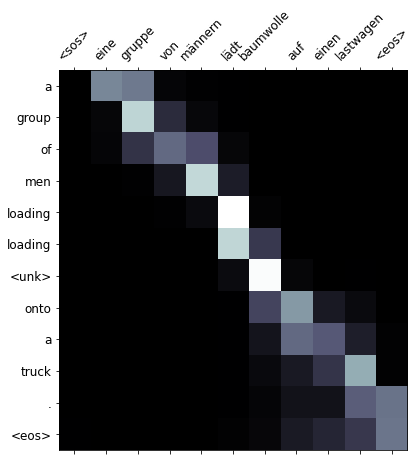

In [ ]:
ix = 0
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attentions = translate(src_sentence, model, temperature=0.9)
print('Prediction:', ' '.join(predictions))

plot_attention(src_sentence, predictions, attentions)

Source: <sos> ein brauner hund rennt dem schwarzen hund hinterher . <eos>
Target: <sos> a brown dog is running after the black dog . <eos>
Prediction: a brown dog is running on the black dog . <eos>


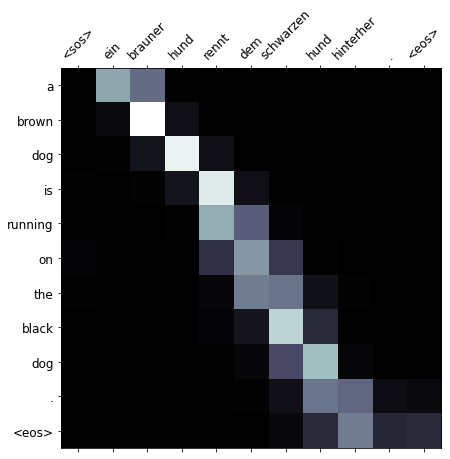

In [ ]:
ix = 6
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attentions = translate(src_sentence, model, temperature=0.9)
print('Prediction:', ' '.join(predictions))

plot_attention(src_sentence, predictions, attentions)

Source: <sos> ein kleines kind steht allein auf einem zerklüfteten felsen . <eos>
Target: <sos> a young child is standing alone on some jagged rocks . <eos>
Prediction: a young child alone on a tree - colored rock . <eos>


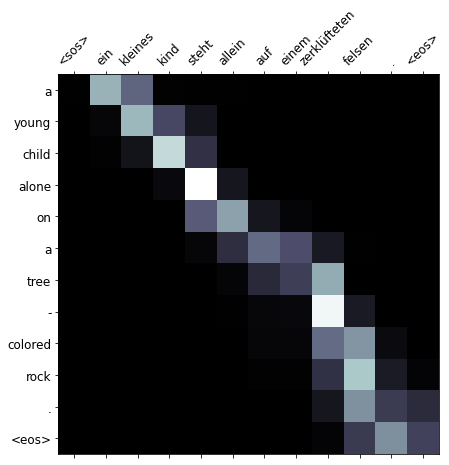

In [ ]:
ix = 10
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attentions = translate(src_sentence, model, temperature=0.9)
print('Prediction:', ' '.join(predictions))

plot_attention(src_sentence, predictions, attentions)

Source: <sos> eine bunt gekleidete frau geht an einem weißen lastwagen vorbei , der mit flaschen gefüllt ist . <eos>
Target: <sos> a woman in a colorful outfit is walking by a white truck filled with bottles . <eos>
Prediction: a woman dressed in walks past a white truck that has graffiti . <eos>


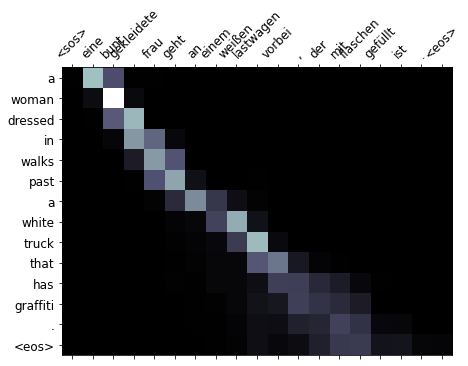

In [ ]:
ix = 64
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attentions = translate(src_sentence, model, temperature=0.9)
print('Prediction:', ' '.join(predictions))

plot_attention(src_sentence, predictions, attentions)

In [ ]:
translations = []
targets = []

for ix in tqdm(range(len(valid_en))):
    src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
    src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
    trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

    predictions, _ = translate(src_sentence, model, max_words=50)

    translations.append(predictions[1:-1])
    targets.append(trg_sentence[1:-1])

100%|██████████| 1014/1014 [01:08<00:00, 14.75it/s]


In [ ]:
smoothie = SmoothingFunction().method7
bleu = corpus_bleu(targets, translations, smoothing_function=smoothie)
print("BLEU: {:.2f}".format(bleu * 100))

BLEU: 31.36
